# Objectives

- To generate a classification model that will be able to predict fraudulent payments before they happen.
- To evaluate this model's accuracy, precison, recall and training time.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

## Overview of the data

The data set is synthentic data generated by the BankSim payment simulator, it can be found [here](https://www.kaggle.com/ntnu-testimon/banksim1). 

In [4]:
df = pd.read_csv('./data/bs140513_032310.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


Existence of null columns: False

Total number of payments: 594643
Total number of fraudulent payments: 7200
Total number of safe payments: 587443

Percentage of fraudulent payments: 1.21%
Percentage of safe payments: 98.79%


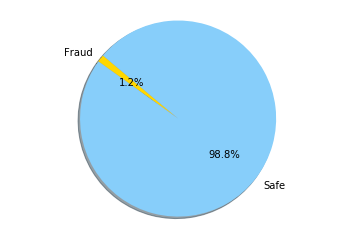

In [5]:
print "Existence of null columns: " + str(df.isnull().values.any()) + "\n"

df_fraud = df[df['fraud']==1]
transaction_count, fraud_transaction_count, safe_transaction_count = len(df), len(df_fraud), len(df) - len(df_fraud)
percent_fraud = round((float(fraud_transaction_count) /  float(transaction_count)) * 100, 2)
percent_safe = 100 - percent_fraud
percent_fraud, percent_safe

print "Total number of payments: " + str(transaction_count)
print "Total number of fraudulent payments: " + str(fraud_transaction_count)
print "Total number of safe payments: " + str(safe_transaction_count) + "\n"
print "Percentage of fraudulent payments: " + str(percent_fraud) + "%"
print "Percentage of safe payments: " + str(percent_safe) + "%"

labels = ['Fraud','Safe']
values = [fraud_transaction_count, safe_transaction_count]
colors = ['gold', 'lightskyblue']
 
# Plot
plt.pie(values, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()


As we can see, there is a huge gap between the number of fraudulent transactions relative to safe transactions.

## Feature Selection & Transformation

### Removing Useless Features

We need to remove features that have just one possible value as they will have no impact whatsoever on the prediction.

In [6]:
df_useful = df.loc[:, (df != df.loc[0]).any()]
df_useful.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


The features `zipcodeOri` and `zipMerchant` have been removed because they only ever have one value (28007).

To further determine which other features are unimportant, we'll use forest of trees to evaluate importances along and their inter-trees variability

Before we can do that however, we need to use `LabelEncoder` to convert the columns with string values because `ExtraTreesClassifier` does not accept any strings in it's `.fit` method.

In [19]:
df_useful = df_useful.apply(LabelEncoder().fit_transform)
df_useful.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,455,0
1,0,2753,2,2,30,12,3968,0
2,0,2285,4,1,18,12,2689,0
3,0,1650,3,2,30,12,1725,0
4,0,3585,5,2,30,12,3572,0


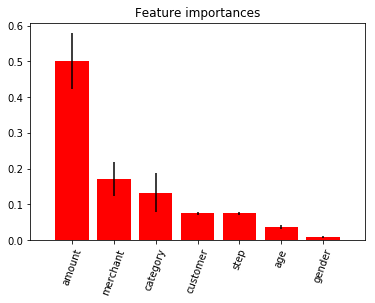

In [7]:
X, y = df_useful.drop(['fraud'], axis = 1), df_useful['fraud']
input_features = df_useful.columns.tolist()
input_features.remove('fraud')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features_sorted = [input_features[i] for i in indices]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), features_sorted, rotation=70)
plt.xlim([-1, X.shape[1]])
plt.show()

From the above, `age` & `gender` are clearly not that important, so they will be discarded.

In [7]:
df_useful = df_useful.drop(['age', 'gender'], axis=1)
X, y = df_useful.drop(['fraud'], axis = 1), df_useful['fraud']
df_useful.head()

,step,customer,merchant,category,amount,fraud
0,0,'C1093826151','M348934600','es_transportation',4.55,0
1,0,'C352968107','M348934600','es_transportation',39.68,0
2,0,'C2054744914','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','M348934600','es_transportation',17.25,0
4,0,'C757503768','M348934600','es_transportation',35.72,0


We're going to take a look at some of the more important features.

In [13]:
df.loc[:, ['merchant','category']].apply(pd.Series.nunique)

merchant    50
category    15
dtype: int64

In [3]:
df['amount'].describe()

count    594643.000000
mean         37.890135
std         111.402831
min           0.000000
25%          13.740000
50%          26.900000
75%          42.540000
max        8329.960000
Name: amount, dtype: float64

Now we're going to look at the number/percentage of fraudulent transactions that appear when the amount is greater than or equal to the 75th percentile.

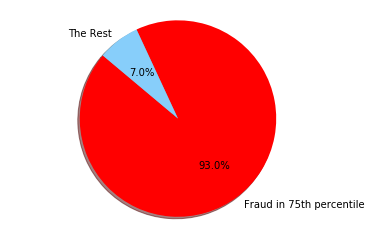

In [8]:
df_75 = df[df.amount >= 42.52]
df_75_fraud = df_75[df_75['fraud']==1]
fraud_75_count = len(df_75_fraud)

labels = ['Fraud in 75th percentile','The Rest']
values = [fraud_75_count, fraud_transaction_count - fraud_75_count]
colors = ['red', 'lightskyblue']
 
# Plot
plt.pie(values, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Let's look at the fraudulent transactions that exist when the amount is equal to or less than the 25th percentile.

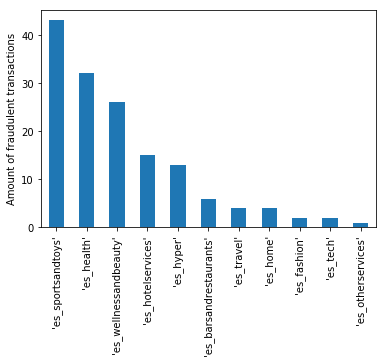

In [9]:
df_25_below = df[df.amount <= 12.74]
df_25_below_fraud = df_25_below[df_25_below['fraud']==1]

pd.value_counts(df_25_below_fraud['category']).plot.bar()
plt.ylabel('Amount of fraudulent transactions')
plt.show()

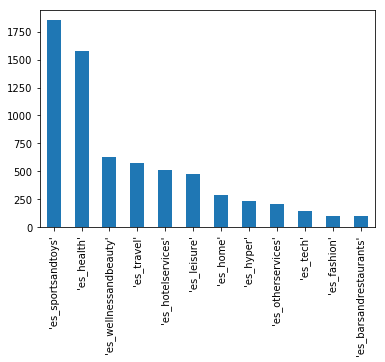

In [43]:
pd.value_counts(df_75_fraud['category']).plot.bar()
plt.show()

## Benchmark

We'll build a naive classifier and use it's score(s) as our benchmark

In [31]:
gnb = GaussianNB()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_true, y_pred = y_test, gnb.fit(X_train,y_train).predict(X_test)

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = gnb.score(X_test, y_test)

msg = "acc: %f, precison: %f, recall: %f, f1: %f" % (accuracy, precision, recall, f1)
print(msg)

acc: 0.972680, precison: 0.638613, recall: 0.903376, f1: 0.702121


## Model Selection

We're looking for a classification model that can handle unbalanced data very well. As we said above, there's a huge disparity between the number of fraudulent cases and safe ones and as such, our data set is very unbalanced. There exist some classifiers in `sklearn` that allow one to set `class_weight='balanced'`. This mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

I'd like to look at a couple of classifiers and pick whichever performs best:
- Logistic Regression
- Random Forests

In [9]:
models = []
models.append(('RFC', RandomForestClassifier(n_estimators=250, random_state=42, class_weight='balanced')))
models.append(('LR', LogisticRegression(class_weight='balanced', random_state=42)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro'}
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scores = cross_validate(model, X, y, scoring=scoring,cv=kfold)
    msg = "%s: acc: %f, precison: %f, recall: %f, time: %f" % (name, scores['test_acc'].mean(), scores['test_prec'].mean(), scores['test_rec'].mean(), scores['fit_time'].mean())
    print(msg)

RFC: acc: 0.995643, precison: 0.947197, recall: 0.863266, time: 76.981691
LR: acc: 0.948668, precison: 0.587334, recall: 0.914796, time: 2.167150


Using KFold cross validation, the above shows the mean accuracy, precision and recall. And from it, we can see that RFC performs better.

These scores are all pretty high for RFC, but let's see if we can reduce the training time while still keeping those high scores. We'll play around with `n_estimators`, `max_features` using GridSearchCV and see which gives the best score(s).

In [10]:
tuned_parameters = {'n_estimators': [10, 20, 25, 30, 45, 50], 
                     'max_features': ['auto', 2]}

scores = ['accuracy', 'precision_macro', 'recall_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)
    y_true, y_pred = y_test, clf.predict(X_test)
    precison = precision_score(y_true, y_pred, average='macro')
    
    print("Best parameters:")
    print(clf.best_params_)
    
    print("%s: %f" % (score, clf.best_score_))
    print("\n")

# Tuning hyper-parameters for accuracy
Best parameters:
{'max_features': 'auto', 'n_estimators': 50}
accuracy: 0.995683


# Tuning hyper-parameters for precision_macro
Best parameters:
{'max_features': 'auto', 'n_estimators': 10}
precision_macro: 0.949439


# Tuning hyper-parameters for recall_macro
Best parameters:
{'max_features': 'auto', 'n_estimators': 45}
recall_macro: 0.865686




In [34]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=42, class_weight='balanced', max_features='auto')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)
start = time.time()
random_forest.fit(X_train, y_train)
end = time.time()

y_true, y_pred = y_test, random_forest.predict(X_test)
fit_time = end - start

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = random_forest.score(X_test, y_test)

msg = "acc: %f, precison: %f, recall: %f, f1: %f, time: %f" % (accuracy, precision, recall, f1, fit_time)
print(msg)

acc: 0.995434, precison: 0.943377, recall: 0.853833, f1: 0.893450, time: 0.517699
